# **1. Setting up**

In [1]:
pip install imbalanced-learn

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score # Import train_test_split function
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn import tree
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from sklearn import tree

In [11]:
print(np.__version__)
print(pd.__version__)




1.23.5
1.5.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/processed_dataset.csv')
print(data.shape)
data.head()

(451325, 19)


,acousticness,artist_name,danceability,duration_m,energy,explicit,instrumentalness,key,liveness,loudness,mode,month,popularity,preview_url,speechiness,tempo,track_id,valence,year
0,0.00126,Headhunterz,0.355,2.943667,0.881,f,0.000002,9,0.0694,-3.962,1,7,26.0,https://p.scdn.co/mp3-preview/4229181352cb0c16...,0.1800,75,7o7Qx3kulN6A0uOaAPf5Vz,0.190,2022
1,0.18700,Headhunterz,0.552,3.902767,0.829,f,0.000054,6,0.2830,-4.988,0,9,51.0,https://p.scdn.co/mp3-preview/4d5c7620737fbd8e...,0.0845,150,0zolxiS5uiL5towOJrsJi4,0.367,2019
2,0.02730,Crossing Colors,0.839,5.818183,0.721,f,0.900000,9,0.0667,-7.721,0,7,9.0,https://p.scdn.co/mp3-preview/d8e54d5d229948b9...,0.0477,110,6AJ1Rk1khe1egig27nXImU,0.768,2018
3,0.01430,Brennan Heart,0.543,3.520000,0.827,f,0.000000,1,0.0842,-3.585,0,5,46.0,https://p.scdn.co/mp3-preview/a8e60e3bd2defda5...,0.0350,150,2KM4KCDbbfOvQ5cgWADd0Z,0.123,2021
4,0.01080,Brennan Heart,0.623,3.946667,0.832,f,0.000000,1,0.0487,-3.348,0,5,17.0,https://p.scdn.co/mp3-preview/758c6b9f2ff9b87b...,0.0566,150,7t2gGVF4Q7QnFM9dt9F0qE,0.439,2021


# **2. Exploring Data and Categorization**

As the feature popularity is the target, it will classify in three categories: Low, Medium and High respectively labeled. The result will be organised in new column called "label". Additionally, features such as artist name, month, preview_url, track_id, year and explicit won't be considered for further analysis so they will be removed.

In [6]:
new_data = data.drop(['artist_name','month','popularity','preview_url','track_id','year','explicit'],axis=1)
new_data['popularity']=data['popularity']
# Label for popularity //
   #1 --> Low,
   #2 --> Medium,
   #3 --> High
new_data['label'] = pd.cut(new_data.popularity, bins=3, labels=[1, 2, 3], right=True)
db = new_data.drop(['popularity'],axis=1)
db.head()

,acousticness,danceability,duration_m,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,label
0,0.00126,0.355,2.943667,0.881,0.000002,9,0.0694,-3.962,1,0.1800,75,0.190,1
1,0.18700,0.552,3.902767,0.829,0.000054,6,0.2830,-4.988,0,0.0845,150,0.367,2
2,0.02730,0.839,5.818183,0.721,0.900000,9,0.0667,-7.721,0,0.0477,110,0.768,1
3,0.01430,0.543,3.520000,0.827,0.000000,1,0.0842,-3.585,0,0.0350,150,0.123,2
4,0.01080,0.623,3.946667,0.832,0.000000,1,0.0487,-3.348,0,0.0566,150,0.439,1


        Samples_qty  Samples_percentage
LOW          436277            0.966658
MEDIUM        14652            0.032464
HIGH            396            0.000877

___________________________________________________________________________



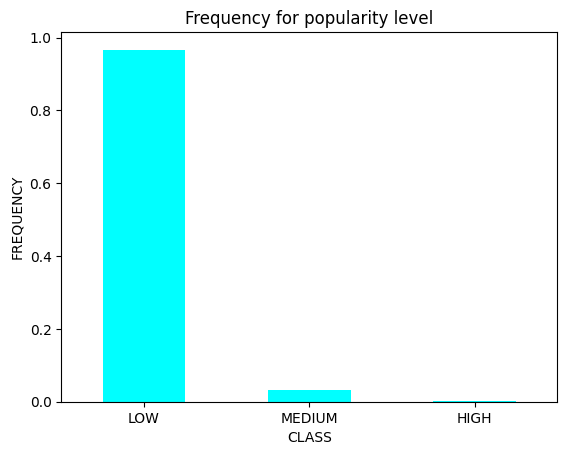

In [7]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))

Samples_qty = db.label.value_counts()
Samples_percentage = db.label.value_counts(normalize=True)
data_transposed = zip(Samples_qty,Samples_percentage)
results = pd.DataFrame(data_transposed, index=['LOW','MEDIUM','HIGH'], columns=["Samples_qty", "Samples_percentage"])
print(results)
print('')
print('___________________________________________________________________________')
print('')
count_classes = pd.value_counts(db['label'], sort = True, normalize=True)
count_classes.plot(kind = 'bar', rot=0, color='cyan')
plt.xticks(range(3),labels=["LOW","MEDIUM","HIGH"])
plt.title("Frequency for popularity level")
plt.xlabel("CLASS",multialignment='center')
plt.ylabel("FREQUENCY", multialignment='center');

It is clear that the category for popularity shows unbalanced distribution being the songs with low popularity with most representation roughly 97%. Therefore, it is necessary to apply some techniques before training this dataset to obtain a balanced dataset; otherwise, it may get high accuracy for the majority class ("Low") and poor recall and precision values for the other class ("Medium" and "High").








# **3. ENGINEERING DATA AND NORMALIZATION**

So far, we have data to begin the analysis. As first step, it will be analysed the most relevant features.

In [8]:
#Separation of features and target in different variables.
X = db.drop(['label'],axis=1)
y = db[['label']]

Within the next cell, it will be highlighted the most relevant columns to perform the classification. The approach about feature selection aims to use as estimator DecisionTreeClassifier.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

select = RFE(DecisionTreeClassifier(random_state = 3000), n_features_to_select = 5)
select.fit(X_train,y_train)
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)
rfe_columns = []
for i in range(len(select.get_support())):
    if select.get_support()[i] == True:
        rfe_columns.append(X.columns[i])

rfe_columns

['acousticness', 'duration_m', 'liveness', 'loudness', 'valence']

In [10]:
rfe_columns.remove('duration_m')
rfe_columns

['acousticness', 'liveness', 'loudness', 'valence']

Once it got the relevant features in the dataset, the rest features will be dropped for our further analysis. Then, the resulting dataset will be scaled into the next methods: minmax, standard and robust methods.

In [11]:
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]

for i in range(len(scalers)):
    #create the scaler
    scaler = scalers[i]
    #fit the scaler to the training data(features only)
    scaler.fit(X)
    if i == 0:
        minmax_scaled = scaler.transform(X)
    elif i == 1:
        standard_scaled = scaler.transform(X)
    elif i == 2:
        robust_scaled = scaler.transform(X)

features_standard_scaled = pd.DataFrame(standard_scaled, columns = X.columns)[rfe_columns]
features_minmax_scaled = pd.DataFrame(minmax_scaled, columns = X.columns)[rfe_columns]
features_robust_scaled = pd.DataFrame(robust_scaled, columns = X.columns)[rfe_columns]
X= pd.DataFrame(X,columns=X.columns)[rfe_columns]

In [12]:
# Dictionary with features both unscaled and scaled to evaluate the performance
all_data = {'UNSCALED FEATURES' : X, 'STANDARD SCALER' : features_standard_scaled, 'MINMAX SCALER' : features_minmax_scaled, 'ROBUST SCALER' : features_robust_scaled}

So far, it will be analysed every input dataset including the non-scaled data, just for appreciating the influence of this previous step.

In [39]:
new_db_ss = features_robust_scaled
new_db_ss['popularity'] = y
new_db_ss['popularity'] = new_db_ss['popularity'].replace([1,2,3],['Low','Medium','High'])
sns.pairplot(new_db_ss, hue="popularity")

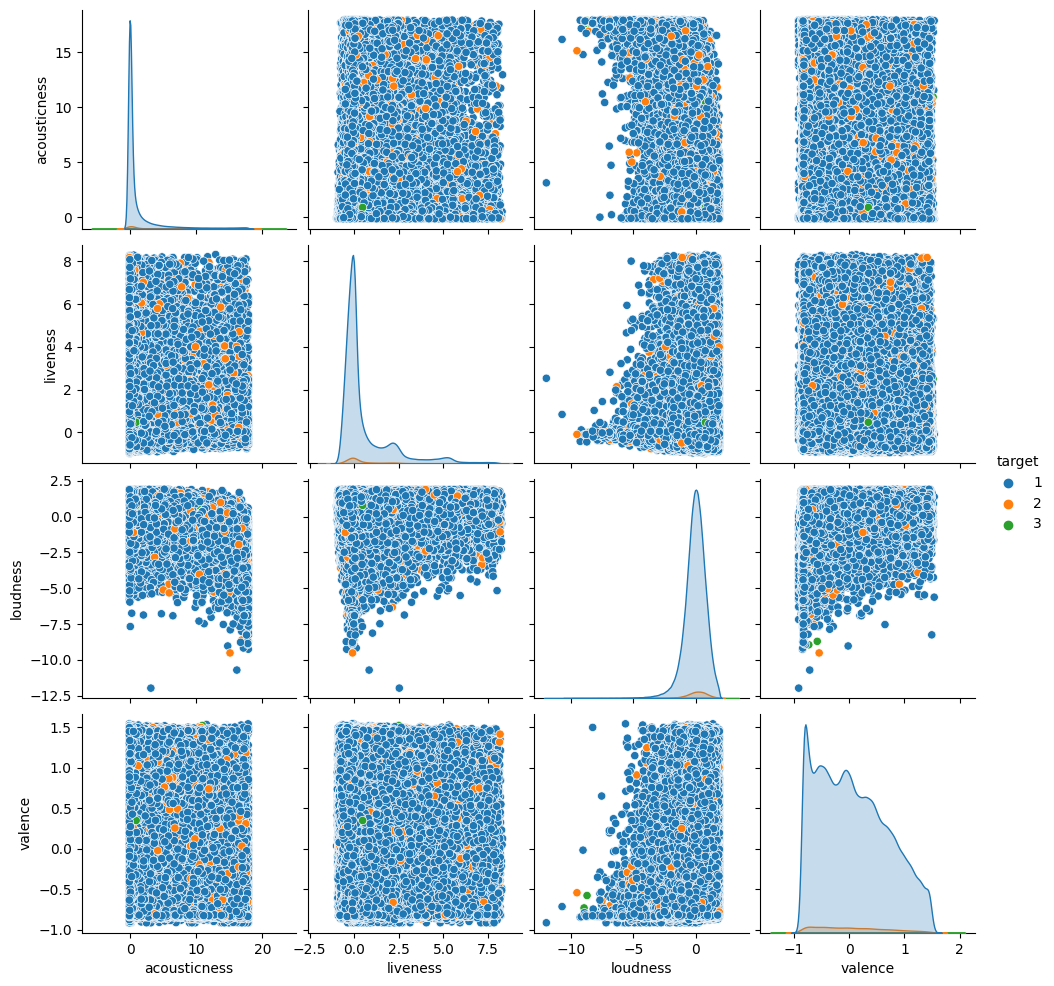

In [40]:
# Distribution of dataset previously to be resampled
sns.pairplot(new_db, hue="target")

In [42]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01
  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  # Predict the function value for the whole gid
  Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# **4. Training dataset**


## **APPROACH 1:**  

# RESAMPLE TECHNIQUE

> **1st:** SMOTE

> **2nd:** SMOTETomek               (SMK)

> **3rd:** Random Over Sampling     (ROS)


## **1st** // Using the technique **SMOTE** with Unscaled, Standard, Min-Max and Robust

UNSCALED FEATURES 
-----------------

              precision    recall  f1-score   support

           1       0.86      0.81      0.83     87002
           2       0.83      0.87      0.85     87510
           3       0.98      0.99      0.99     87255

    accuracy                           0.89    261767
   macro avg       0.89      0.89      0.89    261767
weighted avg       0.89      0.89      0.89    261767

	Prediction accuracy on the training data:  88.53%
	Prediction accuracy on the test data:  88.98%

STANDARD SCALER 
-----------------

              precision    recall  f1-score   support

           1       0.87      0.82      0.85     87002
           2       0.84      0.88      0.86     87510
           3       0.98      0.99      0.99     87255

    accuracy                           0.90    261767
   macro avg       0.90      0.90      0.90    261767
weighted avg       0.90      0.90      0.90    261767

	Prediction accuracy on the training data:  89.35%
	Prediction ac

<Axes: >

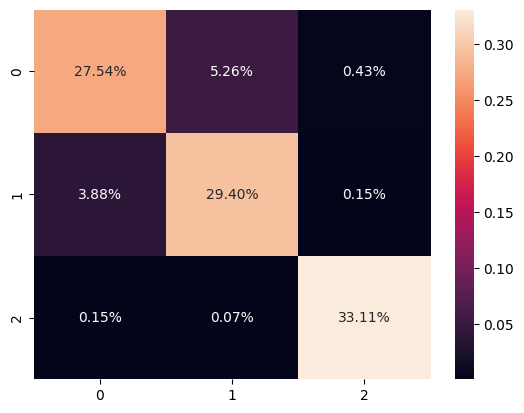

In [19]:
acc_smote_train = []
acc_smote_test = []
for scaler_name, scaler_data in all_data.items():
  new_y = y
  print(scaler_name, '\n-----------------\n')
  classifier1 = DecisionTreeClassifier(max_depth=52, criterion='gini')
  smote = SMOTE(sampling_strategy='auto', random_state=42)
  X_sampled1, y_sampled1 = smote.fit_resample(scaler_data, new_y)
  X_train, X_test, y_train, y_test = train_test_split(X_sampled1, y_sampled1, test_size=0.2, random_state=42)
  classifier1 = classifier1.fit(X_train,y_train)
  training_accuracy = np.mean(cross_val_score(classifier1, X_train,y_train,cv=10))
  acc_smote_train.append(training_accuracy)
  test_accuracy = classifier1.score(X_test, y_test)
  acc_smote_test.append(test_accuracy)
  y_pred = classifier1.predict(X_test)
  print(classification_report(y_test,y_pred))
  print('\t' + f'Prediction accuracy on the training data: {training_accuracy: .2%}')
  print('\t' + f'Prediction accuracy on the test data: {test_accuracy: .2%}\n')
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

## **2nd** // Using the technique **SMK** with Unscaled, Standard, Min-Max and Robust

UNSCALED FEATURES 
-----------------

              precision    recall  f1-score   support

           1       0.86      0.76      0.81     86113
           2       0.79      0.86      0.83     85967
           3       0.96      0.99      0.98     87337

    accuracy                           0.87    259417
   macro avg       0.87      0.87      0.87    259417
weighted avg       0.87      0.87      0.87    259417

	Prediction accuracy on the training data:  87.06%
	Prediction accuracy on the test data:  87.35%

STANDARD SCALER 
-----------------

              precision    recall  f1-score   support

           1       0.85      0.81      0.83     86229
           2       0.83      0.86      0.84     86208
           3       0.98      0.99      0.99     87515

    accuracy                           0.89    259952
   macro avg       0.89      0.89      0.89    259952
weighted avg       0.89      0.89      0.89    259952

	Prediction accuracy on the training data:  88.54%
	Prediction ac

<Axes: >

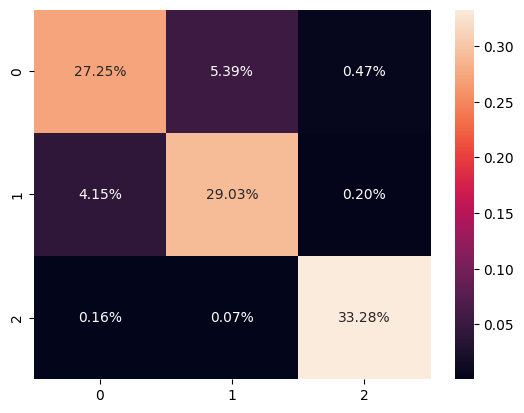

In [13]:
acc_smk_train = []
acc_smk_test = []
for scaler_name, scaler_data in all_data.items():
  new_y = y
  print(scaler_name, '\n-----------------\n')
  classifier2 = DecisionTreeClassifier(max_depth=30,criterion='gini')
  smk = SMOTETomek()
  X_sampled2, y_sampled2 = smk.fit_resample(scaler_data, new_y)
  X_train, X_test, y_train, y_test = train_test_split(X_sampled2, y_sampled2, test_size=0.2, random_state=42)
  classifier2 = classifier2.fit(X_train,y_train)
  training_accuracy = np.mean(cross_val_score(classifier2, X_train,y_train,cv=10))
  acc_smk_train.append(training_accuracy)
  test_accuracy = classifier2.score(X_test, y_test)
  y_pred = classifier2.predict(X_test)
  acc_smk_test.append(test_accuracy)
  print(classification_report(y_test,y_pred))
  print('\t' + f'Prediction accuracy on the training data: {training_accuracy: .2%}')
  print('\t' + f'Prediction accuracy on the test data: {test_accuracy: .2%}\n')
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

In [14]:
acc_1 = test_accuracy

## **3RD** // Using the technique **ROS** with Unscaled, Standard, Min-Max and Robust

UNSCALED FEATURES 
-----------------

              precision    recall  f1-score   support

           1       0.98      0.92      0.95     87002
           2       0.93      0.98      0.95     87510
           3       1.00      1.00      1.00     87255

    accuracy                           0.97    261767
   macro avg       0.97      0.97      0.97    261767
weighted avg       0.97      0.97      0.97    261767

	Prediction accuracy on the training data:  96.71%
	Prediction accuracy on the test data:  96.71%

STANDARD SCALER 
-----------------

              precision    recall  f1-score   support

           1       0.99      0.92      0.95     87002
           2       0.92      0.99      0.95     87510
           3       1.00      1.00      1.00     87255

    accuracy                           0.97    261767
   macro avg       0.97      0.97      0.97    261767
weighted avg       0.97      0.97      0.97    261767

	Prediction accuracy on the training data:  96.69%
	Prediction ac

<Axes: >

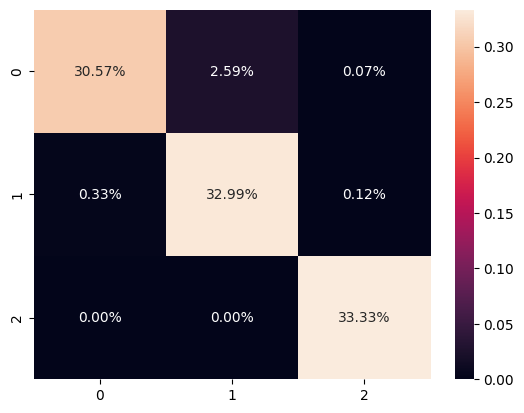

In [21]:
acc_ros_train = []
acc_ros_test = []
for scaler_name, scaler_data in all_data.items():
  new_y = y
  print(scaler_name, '\n-----------------\n')
  classifier3 = DecisionTreeClassifier(max_depth=30,criterion='gini')
  ROS = RandomOverSampler()
  X_sampled3, y_sampled3 = ROS.fit_resample(scaler_data, new_y)
  X_train, X_test, y_train, y_test = train_test_split(X_sampled3, y_sampled3, test_size=0.2, random_state=42)
  classifier3 = classifier3.fit(X_train,y_train)
  training_accuracy = np.mean(cross_val_score(classifier3, X_train,y_train,cv=10))
  acc_ros_train.append(training_accuracy)
  test_accuracy = classifier3.score(X_test, y_test)
  y_pred = classifier3.predict(X_test)
  acc_ros_test.append(test_accuracy)
  print(classification_report(y_test,y_pred))
  print('\t' + f'Prediction accuracy on the training data: {training_accuracy: .2%}')
  print('\t' + f'Prediction accuracy on the test data: {test_accuracy: .2%}\n')
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

_________________________________________________________________________________
## **APPROACH 2:**  
  
*   Resample Technique: SMK
*   Model    : Decision Tree
*   Criterion: Gini
*   Range of depth analysis : 80
*   Class_weights
        *   [2]: 29.77
        *   [3]:1101







In [73]:
new_db_RF = X_sampled_rf
new_db_RF['popularity_sampled'] = y_sampled_rf
new_db_RF['popularity_sampled']=new_db_RF['popularity_sampled'].replace([1,2,3],['Low','Medium','High'])
new_db_RF.head()

,acousticness,liveness,loudness,valence,popularity_sampled
0,-0.118020,-0.371831,0.974183,-0.449631,Low
1,3.249275,1.633803,0.731170,-0.014742,Medium
2,0.354061,-0.397183,0.083847,0.970516,Low
3,0.118383,-0.232864,1.063477,-0.614251,Medium
4,0.054931,-0.566197,1.119612,0.162162,Low


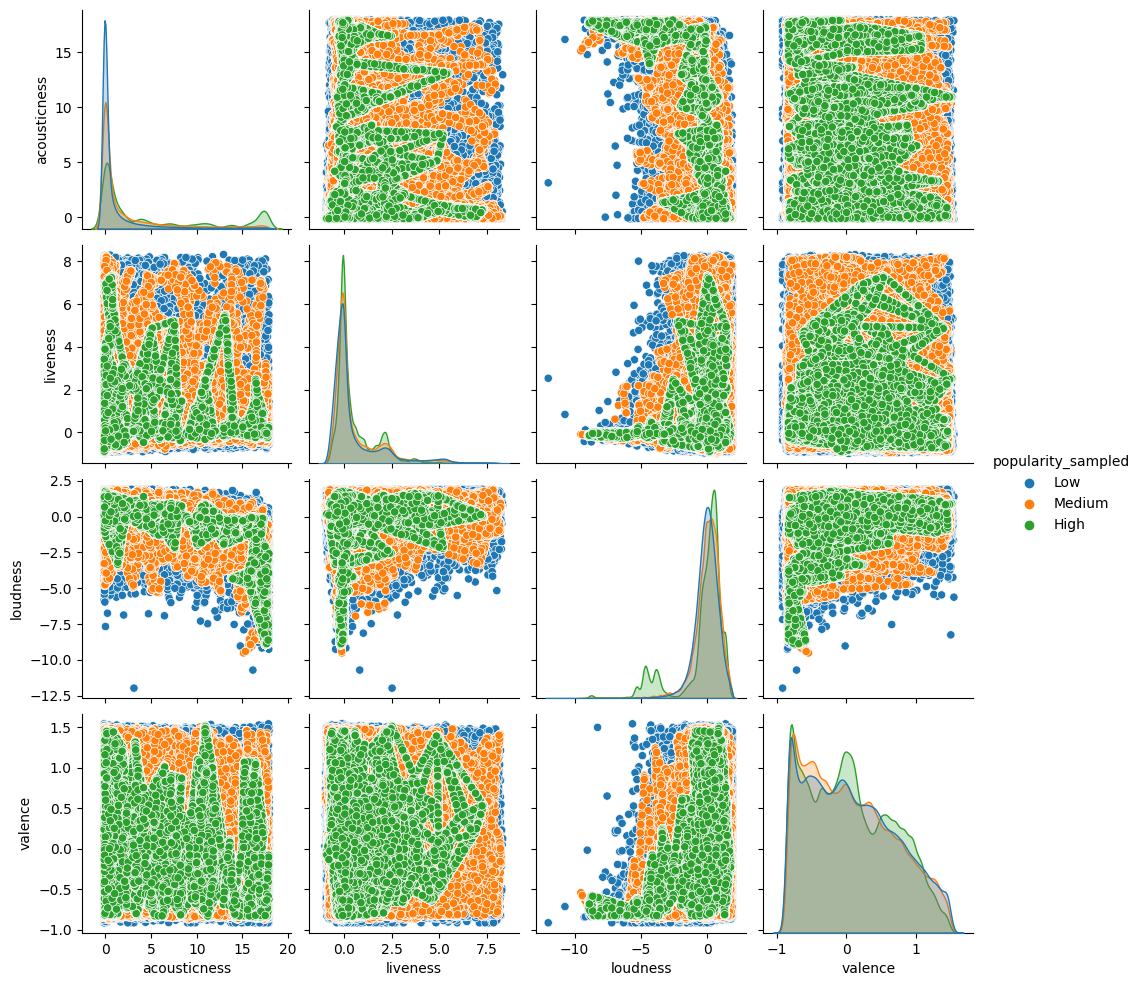

In [74]:
# Distribution of resampled dataset
sns.pairplot(new_db_RF, hue="popularity_sampled")

In [15]:
new_X = features_robust_scaled
new_y = y
smk = SMOTETomek()
X_dt, y_dt = smk.fit_resample(new_X, new_y)

better_score=0
better_depth = None
better_model = None
tm_error_train = []
tm_error_val = []
for i in range(1,80):
  tree_model = tree.DecisionTreeClassifier(criterion='gini',max_depth = i, class_weight={2:29.77, 3:1101})
  X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)
  model = tree_model.fit(X_train,y_train)

  score_test = model.score(X_test,y_test)
  score_train = model.score(X_train, y_train)
  tm_error_train.append(1 - score_train)
  tm_error_val.append(1 - score_test)


  if score_test > better_score:
        better_score = score_test
        better_depth = i
        better_model = tree_model

tree_model = better_model
tree_model.fit(X_train,y_train)




DecisionTreeClassifier(class_weight={2: 29.77, 3: 1101}, max_depth=74)

In [16]:
print("Best depth: ", better_depth)
print("Better accuracy training: ", tree_model.score(X_train,y_train))
print("Better accuracy test: ", tree_model.score(X_test,y_test))

Best depth:  74
Better accuracy training:  0.9999259762720305
Better accuracy test:  0.8987202559488102


In [19]:
acc_2= tree_model.score(X_test,y_test)

 
              precision    recall  f1-score   support

         Low       0.85      0.84      0.85     86150
      Medium       0.85      0.86      0.86     86507
        High       0.98      0.99      0.99     87404

    accuracy                           0.90    260061
   macro avg       0.90      0.90      0.90    260061
weighted avg       0.90      0.90      0.90    260061



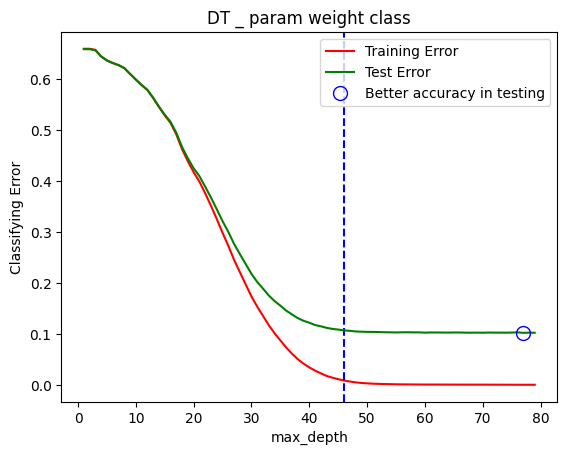

In [27]:
plt.figure()
plt.plot(range(1,80), tm_error_train,
        label='Training Error',
        color='red')
plt.axvline(x = 46, color = 'b', ls='--')
plt.plot(range(1,80), tm_error_val,
        label='Test Error',
        color='green')
plt.plot(better_depth, 1-better_score, 'o', markersize=10, label="Better accuracy in testing", fillstyle="none", c='b', mew=1)
plt.xlabel("max_depth")
plt.ylabel("Classifying Error")
plt.title("DT _ param weight class")
plt.legend(loc=0, numpoints=1)
print(" ")
y_pred = tree_model.predict(X_test)
print(classification_report(y_test,y_pred,target_names=['Low','Medium','High']))
plt.show()


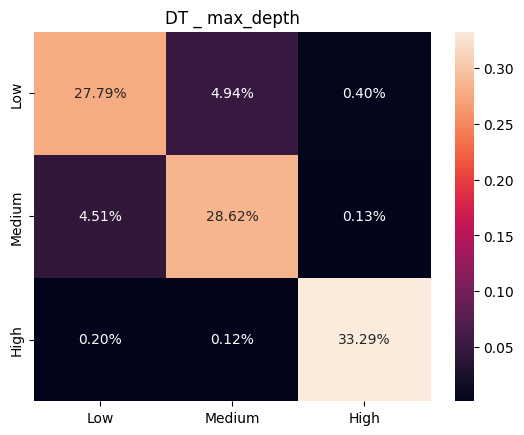

In [25]:
cf_matrix=confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', ax=ax, xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
ax.set_title('DT _ max_depth')
plt.show()

## **APPROACH 3:**  

     
*   Resample Technique: SMK
*   Model    : RANDOMFOREST **(ENSEMBLE MODEL)**
*   Criterion: Gini
*   Range of depth analysis : 110

In [19]:
x_rf = features_robust_scaled
y_rf = y
smk = SMOTETomek()

X_sampled_rf, y_sampled_rf = smk.fit_resample(x_rf, y_rf)
X_train, X_test, y_train, y_test = train_test_split(X_sampled_rf, y_sampled_rf, test_size=0.2, random_state=42)

better_score = 0
better_n_estimators = None
better_model_rf = None
rf_error_train = []
rf_error_val = []

n_estimators_grid = np.linspace(1,101,10).astype(int)  # ~ [1, 11, 21, ..., 101]

for n_estimators in n_estimators_grid:
    print(n_estimators)
    model_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    model_rf.fit(X_train, y_train)

    score_train = model_rf.score(X_train, y_train)
    rf_error_train.append(1 - score_train)

    score_val = model_rf.score(X_test, y_test)
    rf_error_val.append(1 - score_val)

    if score_val > better_score:
        better_score = score_val
        better_n_estimators = n_estimators
        better_model_rf = model_rf

model_rf = better_model_rf
model_rf.fit(X_train, y_train)

print ("Better n_estimators :", better_n_estimators)
print ("Training accuracy RandomForest :", model_rf.score(X_train, y_train))
print ("Testing accuracy RandomForest    :", model_rf.score(X_test, y_test))

1


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


12


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


23


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


34


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


45


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


56


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


67


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


78


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


89


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


101


<ipython-input-19-57016824ae05>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)
<ipython-input-19-57016824ae05>:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


Mejor valor de n_estimators : 101
Exactitud de RandomForest en conjunto de entrenamiento : 0.9999730827206448
Exactitud de RandomForest en conjunto de validación    : 0.9534717388880131


In [29]:
print ("Better n_estimators :", better_n_estimators)
print ("Training accuracy RandomForest :", model_rf.score(X_train, y_train))
print ("Testing accuracy RandomForest    :", model_rf.score(X_test, y_test))

Better n_estimators : 101
Training accuracy RandomForest : 0.9999711553993247
Testing accuracy RandomForest    : 0.9548910639770782


In [31]:
accuracy_approach3 = model_rf.score(X_test, y_test)


In [32]:
acc_3 = round(accuracy_approach3,2)

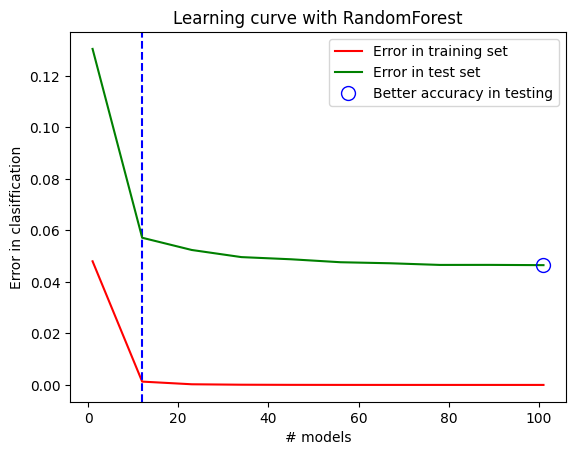

In [21]:
plt.figure()
plt.plot(n_estimators_grid, rf_error_train,
        label='Error in training set',
        color='red')
plt.axvline(x = 12, color = 'b', ls='--')
plt.plot(n_estimators_grid, rf_error_val,
        label='Error in test set',
        color='green')
plt.plot(mejor_n_estimators, 1-mejor_score, 'o', markersize=10,
         label="Better accuracy in testing", fillstyle="none", c='b', mew=1)
plt.xlabel("# models")
plt.ylabel("Error in clasiffication")
plt.title("Learning curve with RandomForest")
plt.legend(loc=0, numpoints=1)
plt.show()

In [22]:
y_pred = modelo_rf.predict(X_test)

              precision    recall  f1-score   support

           1       0.95      0.91      0.93     86135
           2       0.92      0.95      0.94     86482
           3       0.99      1.00      0.99     87440

    accuracy                           0.95    260057
   macro avg       0.95      0.95      0.95    260057
weighted avg       0.95      0.95      0.95    260057

	Prediction accuracy on the training data:  100.00%
	Prediction accuracy on the test data:  95.35%



<Axes: >

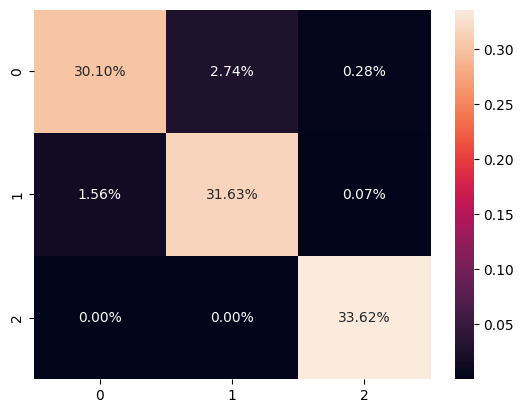

In [23]:
print(classification_report(y_test,y_pred))
print('\t' + f'Prediction accuracy on the training data: {modelo_rf.score(X_train, y_train): .2%}')
print('\t' + f'Prediction accuracy on the test data: {modelo_rf.score(X_test, y_test): .2%}\n')
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

## **5. Results**

# **5.1 Approach 1:**
Once the precision and recall have been validated over 85%, it has the follow results

In [ ]:
# Training results
#accuracy = [acc_smote,acc_smk,acc_ros]
#sd = np.transpose(pd.DataFrame(accuracy))
index = ['unscaled', 'standard', 'min_max', 'robust']
columns = ['SMOTE', 'SMK', 'ROS']
acc_sum_training = pd.DataFrame((zip(acc_smote_train,acc_smk_train,acc_ros_train)),index=index, columns=columns).round(3)
acc_sum_test = pd.DataFrame((zip(acc_smote_test,acc_smk_test,acc_ros_test)),index=index, columns=columns).round(3)
# Values in percentage
acc_sum_training = acc_sum_training*100
acc_sum_training

,SMOTE,SMK,ROS
unscaled,88.5,87.6,96.8
standard,89.4,88.8,96.9
min_max,89.3,88.5,96.9
robust,89.5,89.1,96.8


In [ ]:
# Test results
acc_sum_test = acc_sum_test*100
acc_sum_test

,SMOTE,SMK,ROS
unscaled,89.0,88.2,97.0
standard,89.8,89.4,96.9
min_max,89.9,89.1,97.1
robust,90.0,89.7,96.8


As it can see, combining the sampling techniques and stadardization method, it has got over **89% of accuracy**

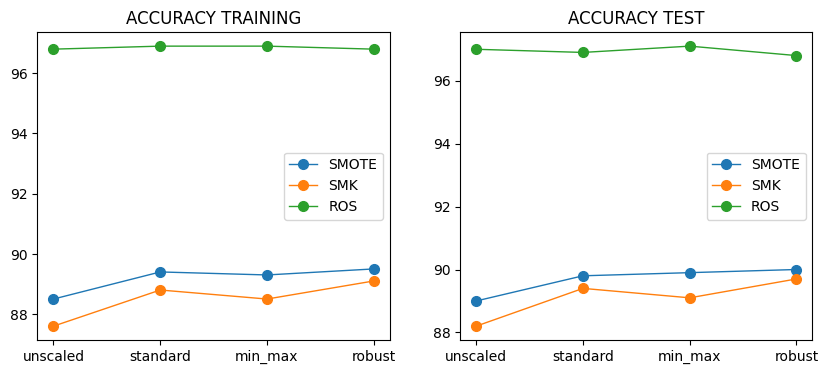

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(acc_sum_training, label=acc_sum_training.columns, marker="o", markersize=7, linewidth=1)
ax[0].set_title('ACCURACY TRAINING')
ax[0].legend()
ax[1].plot(acc_sum_test, label=acc_sum_test.columns, marker="o", markersize=7, linewidth=1)
ax[1].set_title('ACCURACY TEST')
ax[1].legend()
plt.show()

According to the results by mapping the accuracy values considering the different sampling techniques and at the same time the type of standardization, it is clear the best standardization method is **"robustscaler"** as that contributes with a highest accuracy among the different methods of standardization.
Regarding to the sampling techniques is observed that RandomOverSampling (ROS) got the highest accuracy; however it was discarded due to its high accuracy as it may overfitted the model. By contrast, applying **SMOTETomek (SMK)** and SMOTE  got the same values being selected the **SMK** technique since, among these last two, it grants a better accuracy and it is possible to get better generalisation for the classification of the dataset.   

To sum up:
Sampling technique : SMOTETomek
Stadardization method : RobustScaler

# **5.2** **Approach 2:**
Although, the parameter class_weight was modified with a weel high number as coefficient, the training result got good precision but poor recall value. So, the degree of unbalancing was so severe that it was neccesary to apply the resample technique (SMK) before predicting properly under the mentioned condition.

In [26]:
tree_model

DecisionTreeClassifier(class_weight={2: 29.77, 3: 1101}, max_depth=77)

Additionally, it can see in a range from 0 to 80, with the depth of **77** reaches its lowest error; however, it can appreciate from the image below the error converges in depth of 46. If the model is adjusted, it will be reduced the computational cost.

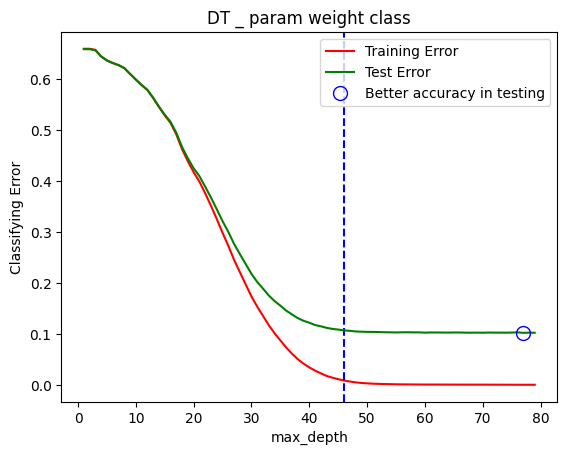

In [30]:
# @title Default title text
plt.figure()
plt.plot(range(1,80), tm_error_train,
        label='Training Error',
        color='red')
plt.axvline(x = 46, color = 'b', ls='--')
plt.plot(range(1,80), tm_error_val,
        label='Test Error',
        color='green')
plt.plot(better_depth, 1-better_score, 'o', markersize=10, label="Better accuracy in testing", fillstyle="none", c='b', mew=1)
plt.xlabel("max_depth")
plt.ylabel("Classifying Error")
plt.title("DT _ param weight class")
plt.legend(loc=0, numpoints=1)
print(" ")
y_pred = tree_model.predict(X_test)
plt.show()

# **5.2** **Approach 3:**
It is probably the best result got under this ensemble method, randomforest. A similar case than before, this classifier works properly with unbalanced data and at the same time is robuts as avoiding to overfit the results. However, as it was mentioned, the unbalancing of dataset is too severe to work just with this sole classifier.
Furthermore, in comparison with second approach, it is noticed that error converges in depth of roughly 12 being the final result of accuracy for this approach: 95.35%
It is the best in comparison with results of previous approaches.



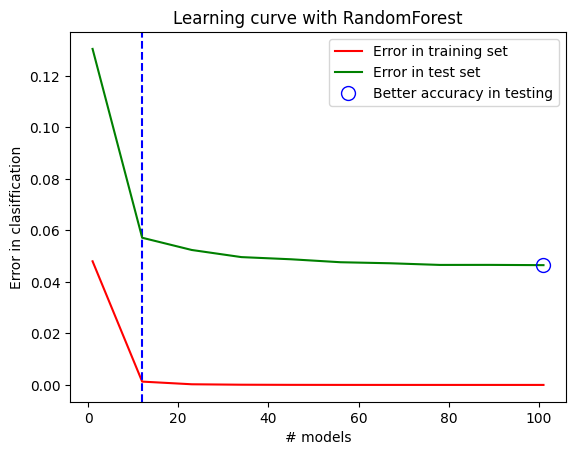

In [25]:
# @title Default title text
plt.figure()
plt.plot(n_estimators_grid, rf_error_train,
        label='Error in training set',
        color='red')
plt.axvline(x = 12, color = 'b', ls='--')
plt.plot(n_estimators_grid, rf_error_val,
        label='Error in test set',
        color='green')
plt.plot(mejor_n_estimators, 1-mejor_score, 'o', markersize=10,
         label="Better accuracy in testing", fillstyle="none", c='b', mew=1)
plt.xlabel("# models")
plt.ylabel("Error in clasiffication")
plt.title("Learning curve with RandomForest")
plt.legend(loc=0, numpoints=1)
plt.show()

Summary of results for approach 1, 2 and 3.

In [67]:
Index = ['Approach 1','Approach 2','Approach 3']
Analysis = ['DT_RS_SMK','DT_Class_Weights','RandomForest']
Accuracy  = [acc_1,acc_2,acc_3]

In [70]:
Data = [[Analysis],
        [Accuracy]]

In [76]:
d = {'Approach':Index, 'Method':Analysis,'Results':Accuracy}
summary = pd.DataFrame(data=d)
summary.sort_values(by=['Results'],ascending=False)

,Approach,Method,Results
2,Approach 3,RandomForest,0.950000
1,Approach 2,DT_Class_Weights,0.898720
0,Approach 1,DT_RS_SMK,0.895643


It is clear that DecisionTreeClassifier is a reliable model for applying in this dataset of spotify's songs as the accuracy got for every method overcomes 89%. This metric has been valid and considered reliable due to values about precision, recall and F1 are very representative (more than 85%). So, about this results we can claim RandomForest (ensemble method based on DecisionTree) presents the highest accuracy.